<a id='section_id'></a>

## Подготовка данных
### Первичный анализ исходных данных

In [1]:
pip install supervenn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from supervenn import supervenn
import datetime
import shap

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [4]:
# прочтем доступные нам датасеты
df_arc = pd.read_csv("/datasets/final_steel/data_arc.csv")
df_bulk = pd.read_csv("/datasets/final_steel/data_bulk.csv")
df_bulk_time = pd.read_csv("/datasets/final_steel/data_bulk_time.csv")
df_gas = pd.read_csv("/datasets/final_steel/data_gas.csv")
df_temp = pd.read_csv("/datasets/final_steel/data_temp.csv")
df_wire = pd.read_csv("/datasets/final_steel/data_wire.csv")
df_wire_time = pd.read_csv("/datasets/final_steel/data_wire_time.csv")

In [5]:
# присвоим имена каждому датасету
df_arc.name = 'данные об электродах'
df_bulk.name = 'данные о подаче сыпучих материалов (объём)'
df_bulk_time.name = 'данные о подаче сыпучих материалов (время)'
df_gas.name = 'данные о продувке сплава газом'
df_temp.name = 'результаты измерения температуры'
df_wire.name = 'данные о проволочных материалах (объём)'
df_wire_time.name = 'данные о проволочных материалах (время)'

In [6]:
# напишем функцию, которая будет производить вывод необходимой информации о датасете
def df_info(df):
    print('Информация по датасету', df.name)
    display(df.head(3))
    df.info()
    display(df.describe().T)
    print('Количество уникальных номеров партий:', df['key'].nunique())  
    print('Количество дубликатов:', df.duplicated().sum())    

#### Анализ данных об электродах

In [7]:
df_info(df_arc)

Информация по датасету данные об электродах


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


Количество уникальных номеров партий: 3214
Количество дубликатов: 0


Сразу видим, что названия столбцов необходимо преобразовать, поскольку в них встречаются строчные буквы и пробелы. Столбцы Начало нагрева дугой и Конец нагрева дугой требуют замены типа данных с object на datetime.

In [8]:
df_arc.columns = ['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой', 'активная_мощность', 'реактивная_мощность']
df_arc['начало_нагрева_дугой'] = pd.to_datetime(df_arc['начало_нагрева_дугой'], yearfirst = True)
df_arc['конец_нагрева_дугой'] = pd.to_datetime(df_arc['конец_нагрева_дугой'], yearfirst = True)
df_arc.describe(datetime_is_numeric=True)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-02 16:15:28.218203904,2019-07-02 16:18:19.889150208,0.670441,0.452592
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.030002,-715.504924
25%,806.000000,2019-06-02 07:01:09.249999872,2019-06-02 07:04:21,0.395297,0.290991
50%,1617.000000,2019-06-30 09:57:14.500000,2019-06-30 10:01:01,0.555517,0.415962
75%,2429.000000,2019-08-03 13:04:47.750000128,2019-08-03 13:09:14,0.857034,0.637371
max,3241.000000,2019-09-01 04:34:47,2019-09-01 04:36:08,3.731596,2.676388
std,934.571502,NaN,NaN,0.408159,5.878702


In [9]:
# проверим, в хронологическом ли порядке расположены даты и время
display(df_arc['начало_нагрева_дугой'].index.is_monotonic,
df_arc['конец_нагрева_дугой'].index.is_monotonic)

True

True

In [10]:
# обнаружены выбросы в столбце реактивная_мощность, выведем все строки с отрицательными значениями
df_arc_outliers = df_arc.query('реактивная_мощность <= 0')
df_arc_outliers

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


**Основные выводы анализа данных об электродах:**
 - выборка имеет 14876 строк и 5 столбцов;
 - количество уникальных номеров партий 3214; 
 - временной ряд представлен данными за период с мая по сентябрь 2019 года и расположен в хронологическом порядке с неравными интервалами;
 - обнаружен едининичный выброс в столбце Реактивная мощность в виде отрицательного значения (данные по этой партии следует исключить);
 - **данные по общему времени нагрева каждой партии, а также суммарную активную/реактивную мощность можно рассмотреть в качестве количественных признаков для будущей модели**.

#### Анализ данных о подаче сыпучих материалов (объём)

In [11]:
df_info(df_bulk)

Информация по датасету данные о подаче сыпучих материалов (объём)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


Количество уникальных номеров партий: 3129
Количество дубликатов: 0


In [12]:
# названия столбцов необходимо преобразовать
df_bulk.columns = ['key','bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6','bulk_7', 
                   'bulk_8', 'bulk_9', 'bulk_10','bulk_11', 'bulk_12','bulk_13', 'bulk_14', 'bulk_15']

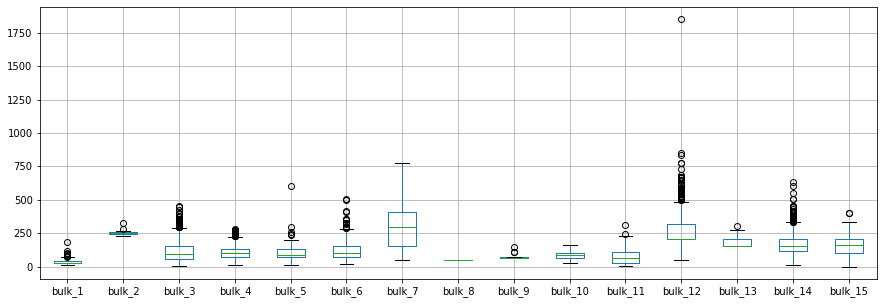

In [13]:
# построим диаграммы размаха для сыпучих материалов
plt.figure(figsize=(15, 5))
df_bulk.boxplot(column=['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6','bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                        'bulk_11', 'bulk_12','bulk_13', 'bulk_14', 'bulk_15'])
plt.show()
# видим сильный выброс по bulk_12, который точно стоит удалить, и менее яркие по остальным материалам
# возможно стоит вернуться к анализу этих данных на этапе работы с признаками

In [14]:
# определим номер партии с сильным выбросом по bulk 12
df_bulk_outliers = df_bulk.query('bulk_12 > 1000')
df_bulk_outliers

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


**Основные выводы анализа данных о подаче сыпучих материалов (объём):**
 - выборка имеет 3129 строк и 16 столбцов;
 - количество уникальных номеров партий 3129; 
 - во всех столбцах bulk_имеются пропуски (данный вид материала не добавлялся в партию), их можно будет заменить на 0;
 - обнаружен сильный выброс в столбце Bulk 12 (данные по этой партии следует исключить);
 - **данные по объему сыпучих материала можно рассмотреть в качестве количественных признаков для будущей модели** (при этом разброс частоты использования того или иного материала очень большой от 1 до 2806).

#### Анализ данных о подаче сыпучих материалов (время)

In [15]:
df_info(df_bulk_time)

Информация по датасету данные о подаче сыпучих материалов (время)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


Количество уникальных номеров партий: 3129
Количество дубликатов: 0


**Основные выводы анализа данных о подаче сыпучих материалов (время):**
 - выборка имеет 3129 строк и 16 столбцов;
 - количество уникальных номеров партий 3129; 
 - **данные о времени загрузки сыпучих материалов не несут полезной нагрузки и в дальнейшей работе использоваться не будут** 

#### Анализ данных о продувке сплава газом

In [16]:
df_info(df_gas)

Информация по датасету данные о продувке сплава газом


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


Количество уникальных номеров партий: 3239
Количество дубликатов: 0


In [17]:
# переименуем столбцы
df_gas.columns = ['key','газ_1']

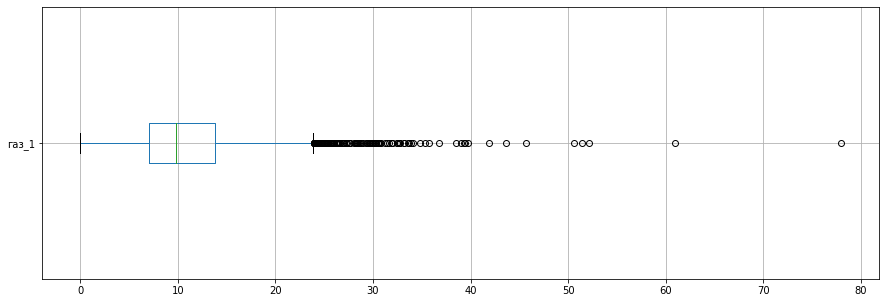

In [18]:
# построим диаграмму размаха 
plt.figure(figsize=(15, 5))
df_gas.boxplot(column=['газ_1'], vert=False)
plt.show()
# видим несколько сильных выбросов со значением свыше 40

In [19]:
# выведем строки с выбросами свыше Q3 + 3*IRQ для последующего удаления
Q1 = df_gas['газ_1'].quantile(q=0.25)
Q3 = df_gas['газ_1'].quantile(q=0.75)
IQR = Q3 - Q1
df_gas_outliers = df_gas.query('газ_1 > (@Q3 + 3*@IQR)')

**Основные выводы анализа данных о продувке сплава газом:**
 - выборка имеет 3239 строк и 2 столбца;
 - количество уникальных номеров партий 3239; 
 - обнаружены выбросы свыше Q3 + 3*IRQ, которые лучше удалить;
 - **данные об объеме газа можно использовать в качестве количественного признака для будущей модели.**

#### Анализ данных о результатах измерения температуры
**В данной таблице расположен наш целевой признак, поэтому рассмотри его более тщательно.**

In [20]:
df_info(df_temp)

Информация по датасету результаты измерения температуры


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,count,mean,std,min,25%,50%,75%,max
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Температура,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


Количество уникальных номеров партий: 3216
Количество дубликатов: 0


In [21]:
# переименуем столбцы, заменим тип данных для столбца со временем и проверим их хронологичность 
df_temp.columns = ['key', 'время_замера', 'температура']
df_temp['время_замера'] = pd.to_datetime(df_temp['время_замера'], yearfirst = True)
display(df_temp.describe(datetime_is_numeric=True).T,
       df_temp.index.is_monotonic)

,count,mean,min,25%,50%,75%,max,std
key,15907.0,1607.88087,1.0,790.0,1618.0,2427.0,3241.0,942.212073
время_замера,15907,2019-07-02 09:55:01.000942848,2019-05-03 11:16:18,2019-06-01 16:24:51.500000,2019-06-30 10:31:14,2019-08-03 12:07:59,2019-09-01 04:38:08,NaN
температура,13006.0,1591.84092,1191.0,1581.0,1591.0,1601.0,1705.0,21.375851


True

In [22]:
# выведем долю пропусков и узнаем количество партий по ним
display(df_temp.isna().mean().sort_values(ascending = False),
df_temp.query('температура.isna()')['key'].nunique())

температура     0.182373
key             0.000000
время_замера    0.000000
dtype: float64

739

Обнаружено 739 партий, в которых имеются пропуски по замеру температуры, что составляет 23% от общего числа партий. Однако поскольку нашим целевым признаком является именно последняя температура партии, **вернемся к вопросу о способе работы с пропусками позднее на этапе выделения целевого признака**.

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

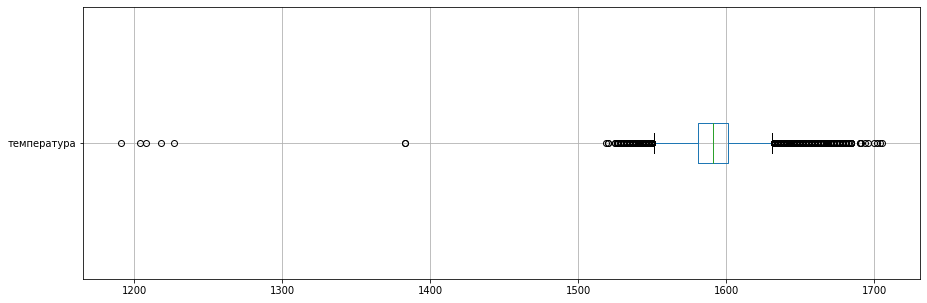

In [23]:
#построим диаграмму размаха по измерениям температуры
plt.figure(figsize=(15, 5))
df_temp.boxplot(column='температура', vert = False)
plt.xlabel

Медианная температура плавки равна 1591 градусу. **Температурные выбросы выше верхней границы ящика с усами показывает область нашей задачи - экономия электроэнергии на излишнем нагреве стали.** Аномально "низкие" значения температуры (ниже 1400 градусов) могут говорить о выплавке другого типа стали и их, возможно, тоже следует исключить. **К вопросу выбросов целесообразно вернуться на этапе работы с целевым признаком**.

In [24]:
# определим диапазон количества замеров темературы по партиям (с учетом пропущенных значений)
display(df_temp['key'].value_counts().value_counts())
df_temp['key'].value_counts().median()

4     862
5     759
3     545
6     473
7     240
8     128
2      78
9      57
10     27
11     21
12     14
16      4
13      3
1       2
15      2
14      1
Name: key, dtype: int64

5.0

**Поскольку нашим целевым признаком является последняя темература по партии, нам не подходят партии, в которых был всего 1 замер (всего таких партий было 2) - удалим их в дальнейшем из нашей выборки.**

In [25]:
df_temp['key'].value_counts().sort_values(ascending=True).head() 

279     1
195     1
1836    2
273     2
1801    2
Name: key, dtype: int64

In [26]:
df_temp_outliers = [279, 195]

**Основные выводы анализа данных о результатах измерения температуры:**
 - **последняя температура по партии является целевым признаком**;
 - выборка имеет 15907 строк и 3 столбца;
 - количество уникальных номеров партий 3216; 
 - обнаружены пропуски (18% от общей выборки) и выбросы в столбце температура - **к вопросам о способе работы с пропусками и выбросами вернемся позднее на этапе выделения целевого признака**;
 - временной ряд представлен данными за период с мая по сентябрь 2019 года и расположен в хронологическом порядке с неравными интервалами;
 - количество измерений температуры сильно варьируется от партии к партии от 1 до 16 (в среднем проводится 5 измерений).

#### Анализ данных о проволочных материалах (объём)

In [27]:
df_info(df_wire)

Информация по датасету данные о проволочных материалах (объём)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


Количество уникальных номеров партий: 3081
Количество дубликатов: 0


In [28]:
# названия столбцов необходимо преобразовать
df_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

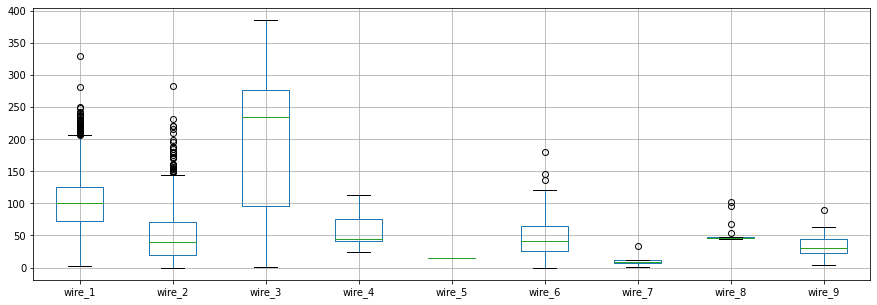

In [29]:
# построим диаграммы размаха для сыпучих материалов
plt.figure(figsize=(15, 5))
df_wire.boxplot(column=['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'])
plt.show()
# наибольшее количество выбросов приходится на наиболее часто используемые wire_1 и wire_2 
# возможно стоит вернуться к анализу этих данных на этапе работы с признаками

**Основные выводы анализа данных о проволочных материалах (объём):**
 - выборка имеет 3081 строк и 10 столбцов;
 - количество уникальных номеров партий 3081; 
 - во всех столбцах wire_имеются пропуски (данный вид материала не добавлялся в партию), их можно будет заменить на 0;
 - **данные по объему проволочных материалов можно рассмотреть в качестве количественных признаков для будущей модели** (при этом разброс частоты использования того или иного материала очень большой от 1 до 3055).

#### Анализ данных о проволочных материалах (время)

In [30]:
df_info(df_wire_time)

Информация по датасету данные о проволочных материалах (время)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


Количество уникальных номеров партий: 3081
Количество дубликатов: 0


Столбцы wire_требуют замены типа данных с object на datetime.

**Основные выводы анализа данных  о проволочных материалах (время):**
 - выборка имеет 3081 строк и 10 столбцов;
 - количество уникальных номеров партий 3081; 
  - **данные о времени загрузки проволочных материалов не несут полезной нагрузки и в дальнейшей работе использоваться не будут**

#### Анализ данных о количестве уникальных партий
Как мы видим, количество уникальных номеров партий в датасетах отличается. Определим количество партий, которые присуствуют во всех 7 выборках.

In [31]:
# определим set по столбцу key для каждой выборки
set_df_arc = set(df_arc['key'])
set_df_bulk = set(df_bulk['key'])
set_df_bulk_time = set(df_bulk_time['key'])
set_df_gas = set(df_gas['key'])
set_df_temp = set(df_temp['key'])
set_df_wire = set(df_wire['key'])
set_df_wire_time = set(df_wire_time['key'])

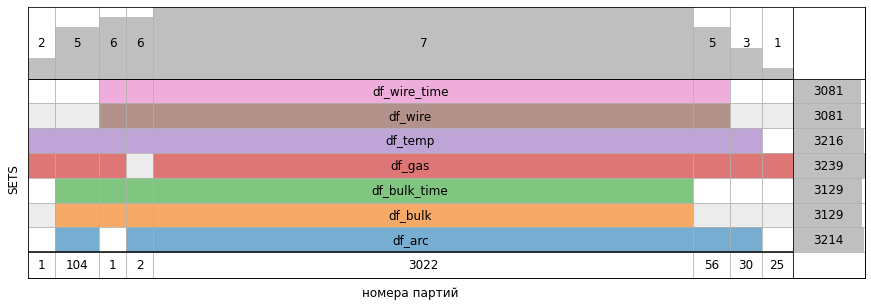

In [32]:
# построим график как соотносятся множества key из всех 7 выборок
plt.figure(figsize=(15, 5))
sets = [set_df_arc, set_df_bulk, set_df_bulk_time, set_df_gas, set_df_temp, set_df_wire, set_df_wire_time]
labels = ['df_arc', 'df_bulk', 'df_bulk_time', 'df_gas', 'df_temp', 'df_wire', 'df_wire_time']
supervenn(sets, labels, widths_minmax_ratio=0.05) #, sets_ordering='minimize gaps'
plt.xlabel('номера партий')
plt.show()

#### Общие выводы по исходным данным

**Основные выводы анализа данных  по всем данным:**
 - целевым признаком  является последняя температура по партии;
 - количество уникальных номеров партий в датасетах находится в диапазоне 3081 - 3239 -  это может говорить как о пропуске данных, так и о факте, что некоторые этапы технологического процесса были пропущены по той или иной причине; 
 -  во всех 7 выборках встречается 3022 партии - это приемлемое значения для последующего объединения объединения датасетов в один и построения модели машинного обучения;
 - временной ряд представлен данными за период с мая по сентябрь 2019 года, которые расположены в хронологическом порядке с неравными интервалами - в связи с этим мы будем строить **регрессионные модели без фактора времени**;
 - обнаружены пропуски и выбросы в столбце температура, к ним мы вернемся на этапе выделения целевого признака;
 - пропуски в столбцах bulk_и wire_можно заменить на 0;
 - обнаружен сильные выбросы в столбцах Реактивная мощность, Bulk 12 и Газ 1, которые следует исключить из выборки;
 - количество измерений температуры сильно варьируется от партии к партии от 1 измерений до 16 (в среднем проводится 5 измерений);
 - данные по общему времени нагрева каждой партии, суммарную активную/реактивную мощность, объем газа, сыпучих и проволочных материалов, а также первую температуру партии можно рассмотреть в качестве количественных признаков для будущей модели;
 - данные о времени загрузки сыпучих и проволочных материалов не несут полезной нагрузки и в дальнейшей работе использоваться не будут.

[В начало](#section_id)

### Подготовка и изучение признаков
#### Выделение целевого признака

Нашим целевым признаком является последняя температура по партии. Пропуски по ней заполнять некорректно, поэтому их лучше удалить. Но здесь важен порядок действий: **сначала оставим последнюю температуру по партии, а потом уже удалим пропуски**.

In [33]:
# сначала оставим только последние замеры по партиям, в которых было два и более замера температуры
df_temp_last = df_temp.query('key not in @df_temp_outliers')
df_temp_last = df_temp_last.drop_duplicates(subset=['key'], keep='last').reset_index(drop=True)
# теперь удалим пропуски
df_temp_last = df_temp_last.dropna().reset_index(drop=True)
display(df_temp_last.head(3),
        df_temp_last.info(),
        df_temp_last.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           2475 non-null   int64         
 1   время_замера  2475 non-null   datetime64[ns]
 2   температура   2475 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 58.1 KB


,key,время_замера,температура
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0


None

,count,mean,std,min,25%,50%,75%,max
key,2475.0,1250.787071,719.787271,1.0,629.5,1252.0,1872.5,2499.0
температура,2475.0,1595.336162,16.023153,1541.0,1587.0,1593.0,1599.0,1700.0


**Таким образом, мы определили 2475 партий для последующего использования при построении модели.**

#### Подготовка признаков
Создадим признаки активная_мощность, реактивная можность и время_нагрева_дугой как сумму для каждой партии.

In [34]:
# сначала посчитаем длительность каждого нагрева в секундах
df_arc['время_нагрева_дугой'] = (df_arc['конец_нагрева_дугой'] - df_arc['начало_нагрева_дугой']).dt.total_seconds()
# дополнительные признаки, которые не помогли улучшить MAE
# df_arc['Полная мощность'] = (df_arc['активная_мощность']**2 + df_arc['реактивная_мощность']**2)**0.5
# df_arc['Энергия'] = df_arc['Полная мощность']*df_arc['время_нагрева_дугой']
df_arc.head(3)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,время_нагрева_дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0


In [35]:
# теперь суммируем активную и реактивную мощности, а также время нагрева дугой для каждой партии
df_arc = df_arc.pivot_table(index='key', values=['активная_мощность','реактивная_мощность', 'время_нагрева_дугой'], aggfunc = 'sum')
df_arc.head(3)

,активная_мощность,время_нагрева_дугой,реактивная_мощность
key,,,
1,4.878147,1098.0,3.183241
2,3.052598,811.0,1.998112
3,2.525882,655.0,1.599076


In [36]:
# выделим первый замер температуры как отдельный признак
df_temp_first = df_temp.drop_duplicates(subset=['key'], keep='first').reset_index(drop=True)
df_temp_first = df_temp_first.rename(columns={'температура':'первый_замер_температуры'})
df_temp_first  = df_temp_first .drop(['время_замера'], axis=1)
display(df_temp_first.head(3),
        df_temp_first.describe().T)

,key,первый_замер_температуры
0,1,1571.0
1,2,1581.0
2,3,1596.0


,count,mean,std,min,25%,50%,75%,max
key,3216.0,1622.199316,935.088523,1.0,815.75,1622.5,2431.25,3241.0
первый_замер_температуры,3216.0,1588.592040,29.137454,1191.0,1572.00,1588.0,1606.00,1684.0


In [37]:
# заполним пропуски нулями в таблицах bulk_и wire_и добавим итоговые столбцы 
df_bulk = df_bulk.fillna(0)
df_wire = df_wire.fillna(0)
df_bulk = df_bulk.assign(bulk_total= df_bulk.iloc[:, 1:16].sum(axis=1))
df_wire = df_wire.assign(wire_total= df_wire.iloc[:, 1:10].sum(axis=1))
display(df_bulk.head(3),
        df_wire.head(3))

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_total
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157


[В начало](#section_id)

### Матрица корреляций количественных признаков
**Поскольку у нас довольно много разных видов сыпучих и проволочных материалов, перед объединением данных выведем по ним матрицы корреляции отдельно.**

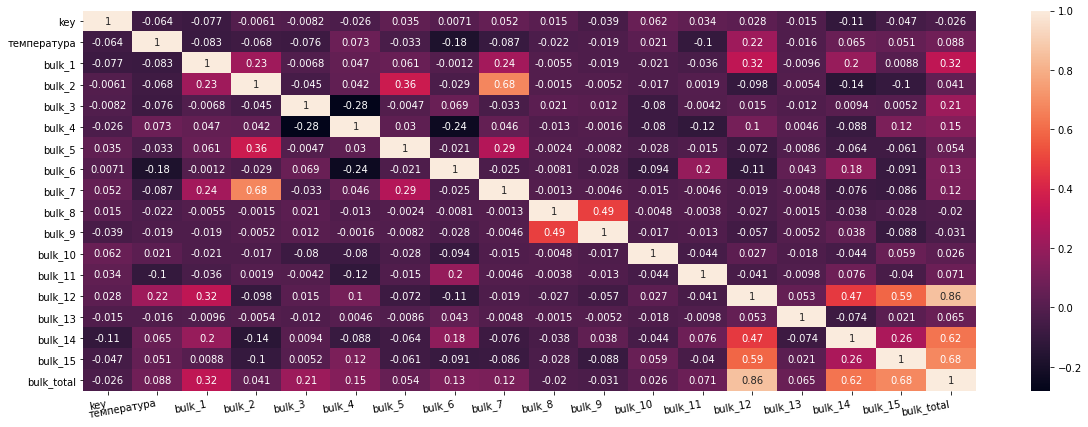

In [38]:
#построим корреляционную матрицу для сыпучих материалов и целевого признака
df_bulk_t = df_temp_last.merge(df_bulk, on = 'key', how='inner')
plt.figure(figsize=(20,7))
g = sns.heatmap(df_bulk_t.corr(),annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=10, horizontalalignment='right')
plt.show()

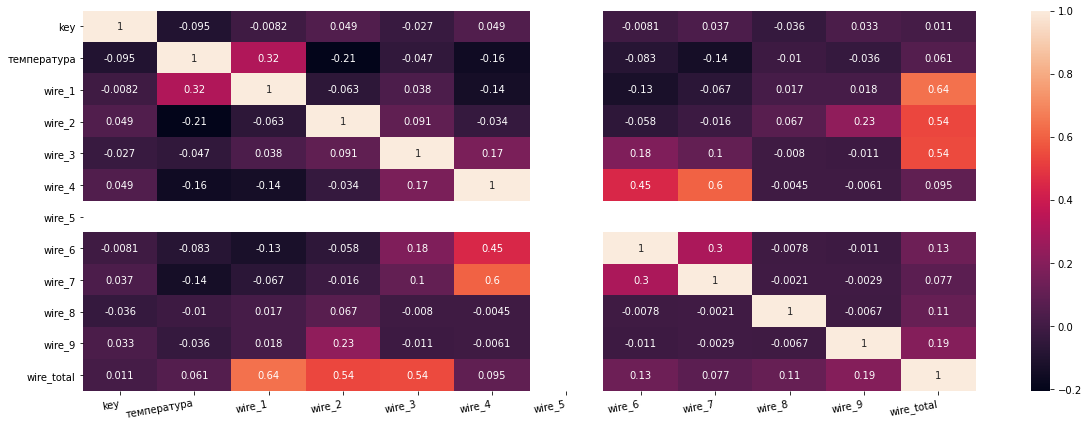

In [39]:
#построим корреляционную матрицу для проволочных материалов 
df_wire_t = df_temp_last.merge(df_wire, on = 'key', how='inner')
plt.figure(figsize=(20,7))
g = sns.heatmap(df_wire_t.corr(),annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=10, horizontalalignment='right')
plt.show()

Непосредственно между целевым признаком и материалами коэффициенты корреляции незначительные.
Высокий коэффициент корреляции по bulk_total и wire_total показывает нам материалы, которые чаще всего используются при выплавке.
Оставим те из них, у которых значение не ниже 0.1. Стоит отметить высокий коэффициент корреляции между bulk 2 и bulk 7, однако использование bulk 2 незначительно в общей выборке и его можно удалить.

In [40]:
# оставим материалы, у которых коэффициенты корреяляции выше 0.1
df_bulk = df_bulk.drop(['bulk_2', 'bulk_5', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_13' ], axis=1)
df_wire = df_wire.drop(['wire_4', 'wire_5', 'wire_7'], axis=1)

In [41]:
# теперь объединим все признаки в единый датасет
df = (df_temp_last.merge(df_temp_first, on = 'key', how='inner')
      .merge(df_arc, on = 'key', how='inner')
      .merge(df_gas, on = 'key', how='inner')
      .merge(df_bulk, on = 'key', how='inner')
      .merge(df_wire, on = 'key', how='inner'))
display(df.head(3),
        df.shape,
        df.describe().T)

,key,время_замера,температура,первый_замер_температуры,активная_мощность,время_нагрева_дугой,реактивная_мощность,газ_1,bulk_1,bulk_3,...,bulk_14,bulk_15,bulk_total,wire_1,wire_2,wire_3,wire_6,wire_8,wire_9,wire_total
0,1,2019-05-03 11:30:39,1613.0,1571.0,4.878147,1098.0,3.183241,29.749986,0.0,0.0,...,150.0,154.0,553.0,60.059998,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,2019-05-03 11:59:12,1602.0,1581.0,3.052598,811.0,1.998112,12.555561,0.0,0.0,...,149.0,154.0,582.0,96.052315,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,2019-05-03 12:34:57,1599.0,1596.0,2.525882,655.0,1.599076,28.554793,0.0,0.0,...,152.0,153.0,544.0,91.160157,0.0,0.0,0.0,0.0,0.0,91.160157


(2329, 24)

,count,mean,std,min,25%,50%,75%,max
key,2329.0,1251.832546,714.762400,1.000000,630.000000,1255.000000,1868.000000,2499.000000
температура,2329.0,1593.365393,11.200915,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
первый_замер_температуры,2329.0,1586.718763,28.290792,1191.000000,1571.000000,1587.000000,1603.000000,1660.000000
активная_мощность,2329.0,3.152449,1.425290,0.186226,2.173277,3.028334,3.920676,17.496497
время_нагрева_дугой,2329.0,807.647488,340.838388,57.000000,581.000000,778.000000,993.000000,4189.000000
реактивная_мощность,2329.0,2.043852,14.895245,-714.591636,1.626854,2.234997,2.915089,12.587990
газ_1,2329.0,11.375600,6.392041,0.008399,7.282948,10.100950,14.216688,77.995040
bulk_1,2329.0,3.427651,12.412132,0.000000,0.000000,0.000000,0.000000,185.000000
bulk_3,2329.0,47.348218,75.310430,0.000000,0.000000,0.000000,80.000000,454.000000
bulk_4,2329.0,37.303564,58.643238,0.000000,0.000000,0.000000,77.000000,281.000000


**Минимальные значения столбцов bulk_total, wire_total и газ_1 говорят нам об отсутствии в выборке партий, где вообще ничего добавляли. После объединения всех признаков в единый датасет выбросы по температуре исчезли, но остались выбросы по Реактивной мощности, bulk_12 и газ_1 - их следует удалить.**

In [42]:
# удалим партии с выбросами
df_outliers = (df_gas_outliers['key'].tolist() + 
               df_arc_outliers['key'].tolist() + 
               df_bulk_outliers['key'].tolist() +
               df_temp_outliers)
df = df.query('key not in@df_outliers') 

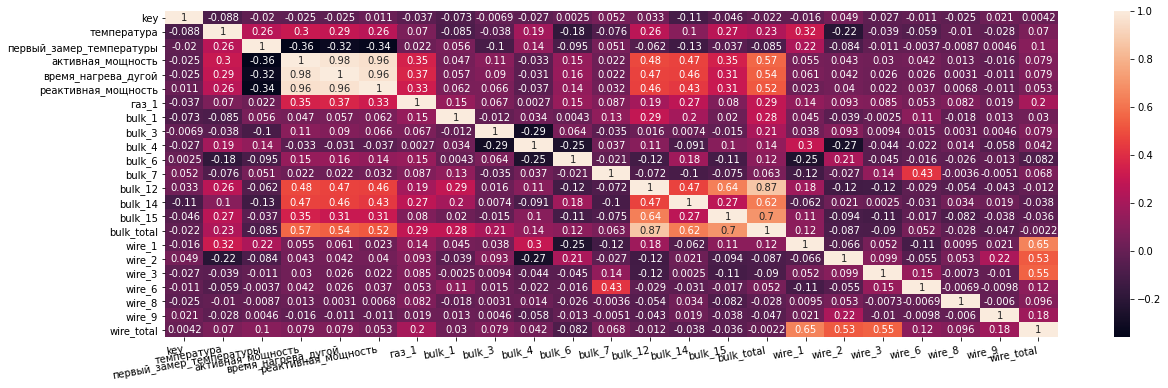

In [43]:
# посторим матрицу корреляции для финального датасета
plt.figure(figsize=(20,6))
g = sns.heatmap(df.corr(),annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=10, horizontalalignment='right')
plt.show()

*Мы наблюдаем мультиколлинеарность между следующими парами (коэффициент корреляции выше 0,6):
 * активная мощность и реактивная мощность
 * время нагрева дугой и активная мощность
 * время нагрева дугой и реактивная мощность
 * bulk 12 и bulk 15
 
Оставим те из них, которую имеют более крепку связь с нашим целевым признаком: активная_мощность

In [44]:
# удалим лишние столбцы
df = df.drop(['key', 'bulk_total', 'wire_total', 'реактивная_мощность',
              'время_замера', 'время_нагрева_дугой' ], axis=1)
df.shape

(2312, 18)

**Таким образом, мы получили финальную выборку и готовы к построению модели.**

[В начало](#section_id)

### Разделение выборок
Разобьем данные на обучающую и тестовую в соотношении 3:1. 
Далее объявим переменные с признаками и целевым признаком для каждой из полученных выборок.

In [45]:
train, test = train_test_split(df, test_size=0.25, random_state=20220809)
print(train.shape, test.shape)

(1734, 18) (578, 18)


In [46]:
# объявим переменные с признаками и целевым признаком для каждой из полученных выборок
x_train = train.drop(['температура'], axis = 1)
y_train = train['температура']
x_test = test.drop(['температура'], axis = 1)
y_test = test['температура']

[В начало](#section_id)

### Масштабирование количественных признаков
Стандартизируем количественные признаки для обучающей выборки, а для тестовой используем ранее запомненные параметры.

In [47]:
scaler = StandardScaler()
numeric =  ['активная_мощность', 'газ_1', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_7', 'bulk_12',
       'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_6', 'wire_8', 'wire_9']
x_train[numeric] = scaler.fit_transform(x_train[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])

[В начало](#section_id)

## Обучение моделей

Обучим разные регрессионные модели и оценим их качество кросс-валидацией.

### Модели линейной регрессии

In [48]:
%%time
lr = LinearRegression()
mae_lr = -cross_val_score(lr, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
print("МАЕ:",  "{:,.2f}".format(mae_lr))

МАЕ: 6.65
CPU times: user 54.9 ms, sys: 35.6 ms, total: 90.5 ms
Wall time: 48.7 ms


In [49]:
%%time
# регуляризация Лассо
lasso = Lasso()
mae_lasso = -cross_val_score(lasso, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
print("МАЕ:",  "{:,.2f}".format(mae_lasso))

МАЕ: 6.83
CPU times: user 142 ms, sys: 179 ms, total: 321 ms
Wall time: 304 ms


In [50]:
%%time
# регуляризация Риджа
rr = Ridge(alpha=1.0) 
mae_rr = -cross_val_score(rr, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
print("МАЕ:",  "{:,.2f}".format(mae_rr))

МАЕ: 6.65
CPU times: user 90.8 ms, sys: 92.2 ms, total: 183 ms
Wall time: 117 ms


In [51]:
%%time
# регуляризация ElasticNet
elastic = ElasticNetCV() 
mae_elastic = -cross_val_score(elastic, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
print("МАЕ:",  "{:,.2f}".format(mae_elastic))

МАЕ: 6.68
CPU times: user 1.43 s, sys: 1.86 s, total: 3.29 s
Wall time: 3.3 s


### Решающее дерево

In [52]:
%%time
# подберем гиперпараметры для решающего дерева с помощью GridSearchCV
parametrs = {'max_depth': range (1, 21)}
dtr = DecisionTreeRegressor(random_state=20220809)
grid = GridSearchCV(dtr, parametrs, scoring = 'neg_mean_absolute_error')
grid.fit(x_train,y_train) 
grid.best_params_

CPU times: user 1.06 s, sys: 50.8 ms, total: 1.11 s
Wall time: 1.13 s


{'max_depth': 4}

In [53]:
dtr = DecisionTreeRegressor(random_state=20220809, max_depth=4)
mae_dtr = -cross_val_score(dtr, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
print("МАЕ:",  "{:,.2f}".format(mae_dtr))   

МАЕ: 7.15


### Случайный лес

In [54]:
%%time
#подберем гиперпараметры для случайного леса с помощью GridSearchCV
parametrs = { 'n_estimators': range (10, 101, 10),
               'max_depth': range (1, 6)}
rfr = RandomForestRegressor(random_state=20220809)
grid = GridSearchCV(rfr, parametrs, scoring = 'neg_mean_absolute_error', n_jobs=-1, verbose = 1)
grid.fit(x_train,y_train) 
grid.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 33.4 s, sys: 200 ms, total: 33.6 s
Wall time: 33.6 s


{'max_depth': 5, 'n_estimators': 100}

In [55]:
%%time
# оценим значения на валидационной выборке c подобранными гиперпараметрами
rfr = RandomForestRegressor(random_state=20220809, n_estimators=90, max_depth=5)
mae_rfr = -cross_val_score(rfr, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
print("МАЕ:",  "{:,.2f}".format(mae_rfr))  

МАЕ: 6.28
CPU times: user 1.47 s, sys: 12.7 ms, total: 1.48 s
Wall time: 1.49 s


### Градиентный бустинг CatBoost

In [56]:
%%time
cb = CatBoostRegressor(loss_function="MAE", verbose = 0, random_seed=20220809)
mae_cb = -cross_val_score(cb, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
print("МАЕ:",  "{:,.2f}".format(mae_cb))

МАЕ: 5.80
CPU times: user 11.7 s, sys: 442 ms, total: 12.1 s
Wall time: 15.5 s


### Градиентный бустинг LightGBM

In [57]:
%%time
lg = LGBMRegressor(random_state=20220809)
mae_lg = -cross_val_score(lg, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
print("МАЕ:",  "{:,.2f}".format(mae_lg))

МАЕ: 6.18
CPU times: user 1.95 s, sys: 37.4 ms, total: 1.99 s
Wall time: 1.96 s


### Градиентный бустинг XGBoost

In [58]:
%%time
xgb = XGBRegressor(verbosity  = 0, random_state=20220809)
mae_xgb = -cross_val_score(xgb, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
print("МАЕ:",  "{:,.2f}".format(mae_xgb))

МАЕ: 6.41
CPU times: user 4min 14s, sys: 620 ms, total: 4min 15s
Wall time: 4min 20s


### Константная модель
Построим константную модель, которая будет предсказывать температуру, равную среднему значению по выборке.

In [59]:
%%time
dr = DummyRegressor(strategy='mean')
mae_dr = -cross_val_score(dr, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
print("МАЕ:",  "{:,.2f}".format(mae_dr))

МАЕ: 8.18
CPU times: user 10.4 ms, sys: 29 µs, total: 10.4 ms
Wall time: 9.3 ms


[В начало](#section_id)

## Тестирование модели
Построим сводную таблицу с основными характеристиками обученных моделей.

In [60]:
pd.DataFrame({'Модель': ["Линейная регрессия", 
                         "Регуляризация Лассо",
                         "Регуляризация Риджа",
                         "Регуляризация ElasticNet",
                         "Решающее дерево", 
                         "Случайный лес", 
                         "CatBoost", 
                         "LightGBM", 
                         "XGBoost", 
                         "Константная модель"],
              'MAE': [mae_lr, mae_lasso, mae_rr, mae_elastic, mae_dtr, mae_rfr, mae_cb, mae_lg, mae_xgb, mae_dr]})

,Модель,MAE
0,Линейная регрессия,6.650027
1,Регуляризация Лассо,6.828334
2,Регуляризация Риджа,6.650137
3,Регуляризация ElasticNet,6.682656
4,Решающее дерево,7.147161
5,Случайный лес,6.275547
6,CatBoost,5.797650
7,LightGBM,6.177512
8,XGBoost,6.413644
9,Константная модель,8.177439


**Наилучший результат продемонстрировала модель градиентного бустинга CatBoost. Проверим на ней тестовую выборку и выведем основные влияющие факторы.**

In [61]:
%%time
cb = CatBoostRegressor(loss_function="MAE", random_seed=None, verbose = 0)
cb.fit(x_train, y_train)
predicted_valid = cb.predict(x_test)
mae = mae = mean_absolute_error(y_test, predicted_valid)
print("MAE тестовой выборки:", "{:,.2f}".format(mae))

MAE тестовой выборки: 5.71
CPU times: user 2.57 s, sys: 56 ms, total: 2.63 s
Wall time: 3.31 s


,Feature,Value
0,активная_мощность,26.496371
1,первый_замер_температуры,22.061074
2,wire_1,9.311011
3,wire_2,6.226577
4,газ_1,6.021498


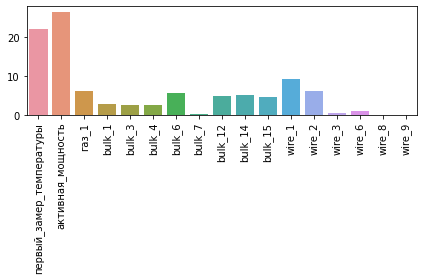

In [62]:
fi = pd.DataFrame({'Feature':x_train.columns,'Value':cb.feature_importances_})
display(fi.sort_values('Value',ascending=False).reset_index(drop=True).head())

sns.barplot(x=x_train.columns, y=cb.feature_importances_)
plt.xticks(rotation=90)
plt.tight_layout()

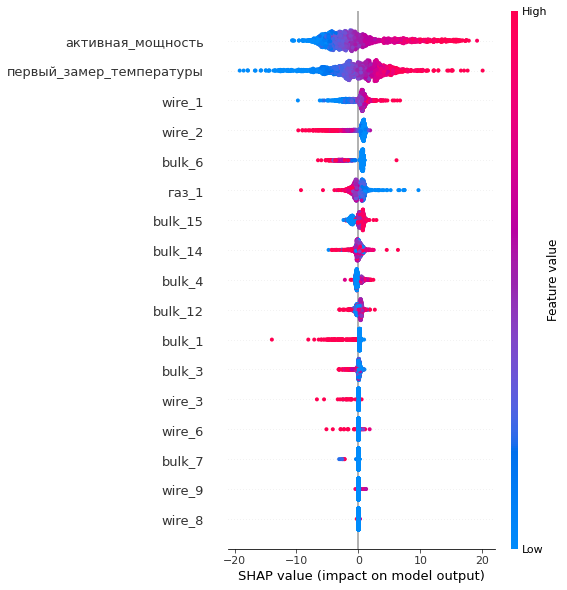

In [63]:
# дополнительно определим важность признаков с помощью библиотеки SHAP
explainer = shap.Explainer(cb)
shap_values = explainer(x_train)
shap.summary_plot(shap_values, x_train)

Чем краснее точки на графике, тем большее значение имеет признак в этой точке. Таким образом, чем выше значения активной мощности и первого замера температуры, тем выше значение целевого признака, т.е. оба признака имеют положительную корреляцию с целевым.

**Основные выводы:**
 * в первую очередь стоит отметить, что все построенные модели, в том числе и константаная модель, продемонстрировали достаточно низкие значения MAE (диапазон от 5.8 до 8.2) при медианном значении целевого признака 1593 - это можно объяснить относительно небольшим разбросом целевого признака (диапазон от 1541 до 1683);
 * **наибольшую точность продемонстрировала модель градиентного бустинга CatBoost (MAE 5.7)**;
 * наибольший вклад в предсказание температуры вносят признаки активная мощность и первичный замер температуры (оба имет положительную корреляцию)

[В начало](#section_id)

## Отчет по решению
<h1> <div align="center"><a> Проект «Температура плавки стали» </a></div>

<font size="4"><b> 1. Введение. </b></font> 

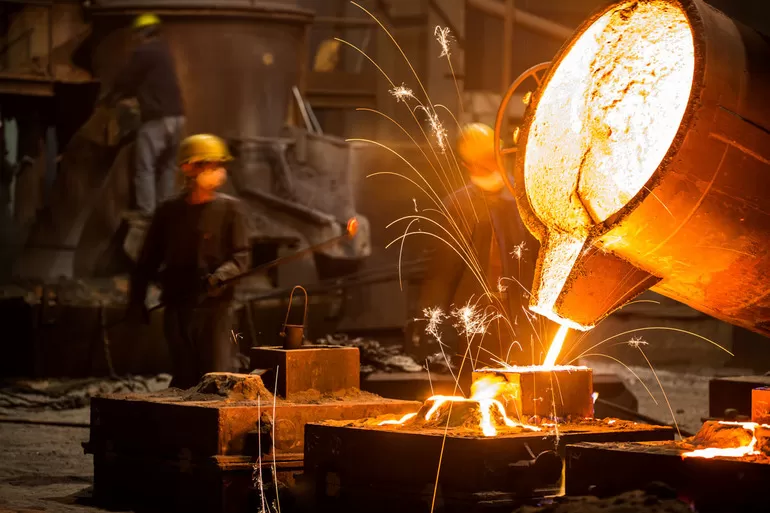

<font size="3"><b> Описание проекта. </b></font>

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.
Метрикой качества  выступает МАЕ.

<font size="2"><b> Описание этапа обработки. </b></font>

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

<font size="3"><b> Исходные данные. </b></font>

Данные представлены семью датасетами, полученными из разных источников:
 1. df_arc - данные об электродах;
 2. df_bulk - данные о подаче сыпучих материалов (объём) -  все добавки это разные материалы;
 3. df_bulk_time - данные о подаче сыпучих материалов (время);
 4. df_gas - данные о продувке сплава газом;
 5. df_temp - результаты измерения температуры;
 6. df_wire - данные о проволочных материалах (объём) -  все добавки это разные материалы;
 7. df_wire_time - данные о проволочных материалах (время).
 
Во всех файлах столбец key содержит номер партии.

<font size="4"><b> 2. Первичный анализ исходных данных. </b></font> 

После первичного анализа всех датасетов можно сделать следующие выводы:

 - названия большинства столбцов необходимо преобразовать, поскольку в них встречаются строчные буквы и пробелы;
 - в столбцах, содержащих дату и время, необходимо изменить тип данных с object на datetime;
 - временной ряд представлен данными за период с мая по сентябрь 2019 года, которые расположены в хронологическом порядке с неравными интервалами - в связи с этим мы будем строить регрессионные модели **без фактора времени**;
 - в связи с предыдущим пунктом  данные о времени загрузки сыпучих и проволочных материалов использоваться не будут;
 - **целевым признаком является последняя температура по партии** (расположен в датасете data_temp.csv);
 - обнаружены пропуски (18% от общей выборки) и выбросы в столбце температура, к ним мы вернемся на этапе выделения целевого признака;
 - пропуски в столбцах bulk и wire можно заменить на 0 (данный вид материала не добавлялся в партию);
 - обнаружены сильные выбросы в столбцах Реактивная мощность, Bulk 12 и Газ 1 (эти партии следует исключить из общей выборки);
 - количество измерений температуры сильно варьируется от партии к партии от 1 измерений до 16 (в среднем проводится 5 измерений);
 - количество уникальных номеров партий в датасетах находится в диапазоне 3081 - 3239, это может говорить как о пропуске данных, так и о факте, что некоторые этапы технологического процесса были пропущены по той или иной причине; 
 -  во всех 7 выборках встречается 3022 партии - это приемлемое значения для последующего объединения объединения датасетов в один и построения модели машинного обучения.

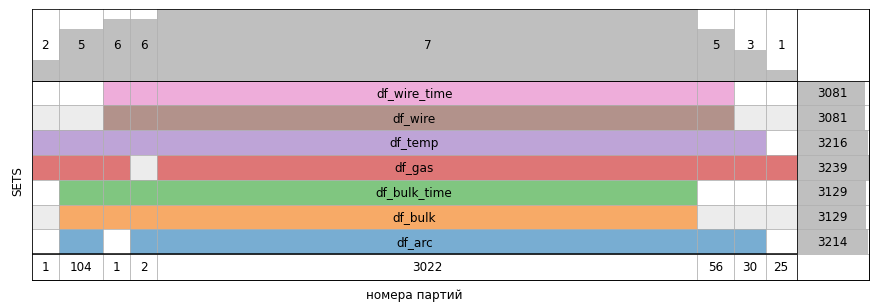

<font size="4"><b> 3. Подготовка и изучение признаков. </b></font> 

В первую очередь следует выделить целевой признак - последний замер температуры по каждой партии. Пропуски по ней заполнять некорректно, поэтому их лучше удалить. Но здесь важен порядок действий: сначала оставим последнюю температуру по партии, а потом уже удалим пропуски. Помимо этого нас интересуют партии, где было хотя бы 2 замера температуы. После обработки данных мы определили 2475 партий для последующего использования при построении модели.

В качестве количественных признаков мы можем рассмотреть данные по активной и реактивной мощности для каждой партии, объем газа, сыпучих и проволочных материалов, а также общее время нагрева электродами каждой партии и первый замер температуры. Помимо этих признаков были рассчитаны Полная мощность и Энергия, однако они не позволили улучшить MAE и поэтому в финальный код не вошли.

Поскольку у нас довольно много разных видов сыпучих (15 видов) и проволочных материалов (9 видов), мы добавили итоговые столбцы и построили по ним матрицы корреляции и целевого признака отдельно. Непосредственно между целевым признаком и материалами коэффициенты корреляции оказались незначительными. Высокий коэффициент корреляции по bulk_total и wire_total показывает нам материалы, которые чаще всего используются при выплавке. Для дальнейшего анализам мы оставили те из них, у которых значение не ниже 0.1.

Итоговый датасет был сформирован путем объединения 5 датасетов: df_temp, df_arc, df_bulk, df_gas и df_wire. Минимальные значения столбцов bulk_total, wire_total и газ_1 выше нуля говорят нам об отсутствии в выборке партий, где вообще ничего добавляли. После объединения выбросы по температуре исчезли, осталось исключить партии с найденными ранее выбросами по другим признакам, а также те, где был всего один замер температуры. Далее мы построили матрицу корреляции для финального датасета, где обнаружили мультиколлинеарность (коэффициент близок к 1) между следующими тремя признаками: активная мощность, реактивная мощность и время нагрева дугой. В итоговом датасете оставили тот, у которого более крепка связь с целевым признаком: активная мощность. Таким образом, мы получили финальную выборку из 2312 партий с 18 признаками: последний замер темературы (целевой), первый_замер_температуры, активная_мощность, газ_1, bulk_1, bulk_3, bulk_4, bulk_6, bulk_7, bulk_12, bulk_14, bulk_15 и wire_1, wire_2, wire_3, wire_6, wire_8, wire_9.

Финальные данные мы разбили на обучающую и тестовую выборки в соотношении 3:1. Ввиду разности масшатбов мы стандартизировали количественные признаки  с помощь методов fit_transform() для обучающей выборки и transform() для тестовой. 


<font size="4"><b> 3. Моделирование. </b></font> 

Мы обучили 10 регрессионных моделей и оценили их качество кросс-валидацией:
 1. линейная регресиия;
 2. линейная регресиия с регуляризацией Лассо;
 3. линейная регресиия с гребневой регуляризацией (ридж-регрессия);
 4. линейная регресиия с регуляризацией ElasticNet;
 5. решающее дерево (max_depth: 4);
 6. случайный лес (max_depth: 5, n_estimators: 100);
 7. градиентный бустинг CatBoost (дефолтные параметры);
 8. градиентный бустинг LightGBM (дефолтные параметры);
 9. градиентный бустинг XGBoost (дефолтные параметры);
 10. константная модель (предсказывает температуру, равной среднему значению по выборке).
 
<font size="4"><b> 4. Результаты и выводы </b></font> 

В первую очередь стоит отметить, что все построенные модели, в том числе и константаная модель, продемонстрировали достаточно низкие значения MAE (диапазон от 5.8 до 8.2) при медианном значении целевого признака 1593 - это можно объяснить относительно небольшим разбросом целевого признака (диапазон от 1541 до 1683).
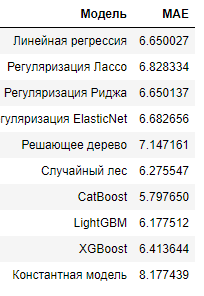

Наибольшую точность продемонстрировала модель градиентного бустинга CatBoost (MAE 5.7 на тестовой выборке).

С помощью feature importances и библиотеки SHAP мы определили, что наибольший вклад в предсказание температуры вносят признаки активная мощность и первичный замер температуры (оба имет положительную корреляцию).
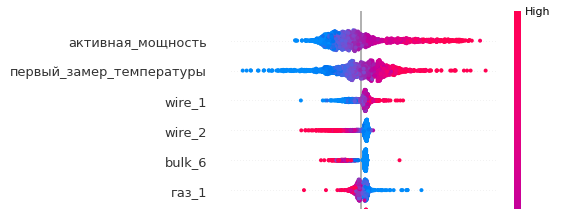

Поскольку главной целью заказчика является экономия электроэнергии, то управляя этими параметрами, мы сможем регулировать энергозатраты. В качестве дальнейших шагов можно предложить заказчику разработку мероприятий для этого решения. Отдельно стоит изучить сильные выбросы целевого признака с определением влияющих на них факторов производства. Это поможет уменьшить разброс целевого признака, а значит и неэффективное использование ресурсов. В этом плане наша модель станет хорошим началом работы над энергоэффективностью.
 
Составленный план решения задачи был выполнен нами в полном объеме. Основными трудностями в процессе работы были выбросы, а также выявление ключевых признаков. Выбросы были исключены с помощью построения диаграммы ящик с усами и отсечения их выше границы  Q3 + 3 * IRQ. Что касается признаков, то часть их была исключена благодаря корреляционным матрицам.